# Introduction: Home Credit Default Risk

The objective of this project is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:


* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)


# Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) and an example of the expected submission file. 


The dataframe *application_train* and *application_test* contains the loan and loan applicants. The dataframe *bureau* contains the application data from other loans that the client took from other credit institutions and were reported to the credit bureau. The dataframe *previous_applications* contains information about previous loans at **Home Credit** by the same client, previous loans information and client information at the time of the loan (there is a line in the dataframe per previous loan application).

**SK_ID_CURR** is connecting the dataframes *application_train*|*test* with *bureau*, *previous_application* and also with dataframes *POS_CASH_balance*, *installments_payment* and *credit_card_balance*. **SK_ID_PREV** connects dataframe *previous_application* with *POS_CASH_balance*, *installments_payment* and *credit_card_balance*. **SK_ID_BUREAU** connects dataframe *bureau* with dataframe *bureau_balance*.

We will followed the general outline of a [machine learning project](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420): 

1.  Understand the problem and the data
2. Data cleaning and formatting (this was mostly done for us)
3. Exploratory Data Analysis
4. Baseline model
5.  Improved model
6. Model interpretation (just a little)


## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [4]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
# from plotly import tools
# import plotly.tools as tls
# import squarify
# from mpl_toolkits.basemap import Basemap
# from numpy import array
# from matplotlib import cm

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

## Read in Data 

There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [6]:
pd.set_option("display.max_columns", None)

### 1. application_train

In [7]:
# Load Training data
application_train = pd.read_csv('application_train.csv')
print('Training data shape: ', application_train.shape)
application_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [68]:
application_train["AMT_CREDIT"]

0          406597.5
1         1293502.5
2          135000.0
3          312682.5
4          513000.0
            ...    
307506     254700.0
307507     269550.0
307508     677664.0
307509     370107.0
307510     675000.0
Name: AMT_CREDIT, Length: 307511, dtype: float64

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

### 2. application_test

In [8]:
# Testing data features
application_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', application_test.shape)
application_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

### 3. bureau 

In [9]:
bureau = pd.read_csv('bureau.csv')
print('Bureau data shape: ', bureau.shape)
bureau.head()

Bureau data shape:  (1716428, 17)


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

### 4. bureau_balance

In [10]:
bureau_balance = pd.read_csv('bureau_balance.csv')
print('Bureau_balance data shape: ', bureau_balance.shape)
bureau_balance.head()

Bureau_balance data shape:  (27299925, 3)


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

### 5. previous_application

In [11]:
previous_application = pd.read_csv('previous_application.csv')
print('Previous_application  data shape: ', previous_application.shape)
previous_application.head()

Previous_application  data shape:  (1670214, 37)


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

### 6. credit_card_balance

In [12]:
credit_card_balance = pd.read_csv('credit_card_balance.csv')
print('Credit_card_balance data shape: ', credit_card_balance.shape)
previous_application.head()

Credit_card_balance data shape:  (3840312, 23)


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

### 7. installments_payments

In [13]:
installments_payments = pd.read_csv('installments_payments.csv')
print('Installments_payments data shape: ', installments_payments.shape)
installments_payments.head()

Installments_payments data shape:  (13605401, 8)


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

### 8. POS_CASH_balance

In [14]:
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
print('POS_CASH_balance data shape: ', POS_CASH_balance.shape)
POS_CASH_balance.head()

POS_CASH_balance data shape:  (10001358, 8)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [15]:
import pandas as pd

In [16]:
sample_submission = pd.read_csv('sample_submission.csv')
print('sample_submission data shape: ', sample_submission.shape)
sample_submission.head()

sample_submission data shape:  (48744, 2)


SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [17]:
print('Size of application_train data', application_train.shape)
print('Size of application_test data', application_test.shape)
print('Size of bureau data', bureau.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)


Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of bureau data (1716428, 17)
Size of bureau_balance data (27299925, 3)
Size of POS_CASH_balance data (10001358, 8)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)


# Check for missing data

In [26]:
# Function to calculate missing values by column# 
def missing_value_table(df):
    
    ##total missing value by each column
    mis_val =df.isnull().sum()[df.isnull().sum()>0]
  
    # Percentage of missing values
    mis_val_percent = mis_val/len(df)*100

    #Make a table with the results
    mis_val_table = pd.concat([ mis_val,mis_val_percent], axis=1).rename({0:"Missing values",1:"% Missing values"}, axis=1)
    
    # Print some summary information
    print("Your dataframe contains " + str(df.shape[1]) + " columns\n"
         "There are " + str(df.isnull().sum()[df.isnull().sum()>0].shape[0]) +" columns that have missing values")
    
    return mis_val_table.sort_values(by = "% Missing values", ascending = False) 

**checking missing data in application_train **

In [27]:
missing_value_table(application_train)

Your dataframe contains 122 columns
There are 67 columns that have missing values


Missing values  % Missing values
COMMONAREA_MEDI                   214865         69.872297
COMMONAREA_AVG                    214865         69.872297
COMMONAREA_MODE                   214865         69.872297
NONLIVINGAPARTMENTS_MEDI          213514         69.432963
NONLIVINGAPARTMENTS_MODE          213514         69.432963
...                                  ...               ...
EXT_SOURCE_2                         660          0.214626
AMT_GOODS_PRICE                      278          0.090403
AMT_ANNUITY                           12          0.003902
CNT_FAM_MEMBERS                        2          0.000650
DAYS_LAST_PHONE_CHANGE                 1          0.000325

[67 rows x 2 columns]

**checking missing data in POS_CASH_balance **

In [28]:
missing_value_table(POS_CASH_balance)

Your dataframe contains 8 columns
There are 2 columns that have missing values


Missing values  % Missing values
CNT_INSTALMENT_FUTURE           26087          0.260835
CNT_INSTALMENT                  26071          0.260675

**checking missing data in bureau_balance **

In [29]:
missing_value_table(bureau_balance)

Your dataframe contains 3 columns
There are 0 columns that have missing values


Empty DataFrame
Columns: [Missing values, % Missing values]
Index: []

**checking missing data in previous_application **

In [30]:
missing_value_table(previous_application)

Your dataframe contains 37 columns
There are 16 columns that have missing values


Missing values  % Missing values
RATE_INTEREST_PRIMARY             1664263         99.643698
RATE_INTEREST_PRIVILEGED          1664263         99.643698
AMT_DOWN_PAYMENT                   895844         53.636480
RATE_DOWN_PAYMENT                  895844         53.636480
NAME_TYPE_SUITE                    820405         49.119754
DAYS_FIRST_DRAWING                 673065         40.298129
DAYS_FIRST_DUE                     673065         40.298129
DAYS_LAST_DUE_1ST_VERSION          673065         40.298129
DAYS_LAST_DUE                      673065         40.298129
DAYS_TERMINATION                   673065         40.298129
NFLAG_INSURED_ON_APPROVAL          673065         40.298129
AMT_GOODS_PRICE                    385515         23.081773
AMT_ANNUITY                        372235         22.286665
CNT_PAYMENT                        372230         22.286366
PRODUCT_COMBINATION                   346          0.020716
AMT_CREDIT                              1          0.000060

**checking missing data in installments_payments **

In [31]:
missing_value_table(installments_payments)

Your dataframe contains 8 columns
There are 2 columns that have missing values


Missing values  % Missing values
DAYS_ENTRY_PAYMENT            2905          0.021352
AMT_PAYMENT                   2905          0.021352

**checking missing data in credit_card_balance **

In [32]:
missing_value_table(credit_card_balance)

Your dataframe contains 23 columns
There are 9 columns that have missing values


Missing values  % Missing values
AMT_PAYMENT_CURRENT                 767988         19.998063
AMT_DRAWINGS_ATM_CURRENT            749816         19.524872
AMT_DRAWINGS_OTHER_CURRENT          749816         19.524872
AMT_DRAWINGS_POS_CURRENT            749816         19.524872
CNT_DRAWINGS_ATM_CURRENT            749816         19.524872
CNT_DRAWINGS_OTHER_CURRENT          749816         19.524872
CNT_DRAWINGS_POS_CURRENT            749816         19.524872
AMT_INST_MIN_REGULARITY             305236          7.948208
CNT_INSTALMENT_MATURE_CUM           305236          7.948208

**checking missing data in bureau **

In [33]:
missing_value_table(bureau)

Your dataframe contains 17 columns
There are 7 columns that have missing values


Missing values  % Missing values
AMT_ANNUITY                    1226791         71.473490
AMT_CREDIT_MAX_OVERDUE         1124488         65.513264
DAYS_ENDDATE_FACT               633653         36.916958
AMT_CREDIT_SUM_LIMIT            591780         34.477415
AMT_CREDIT_SUM_DEBT             257669         15.011932
DAYS_CREDIT_ENDDATE             105553          6.149573
AMT_CREDIT_SUM                      13          0.000757

# Data Exploration

## Distribution of AMT_CREDIT

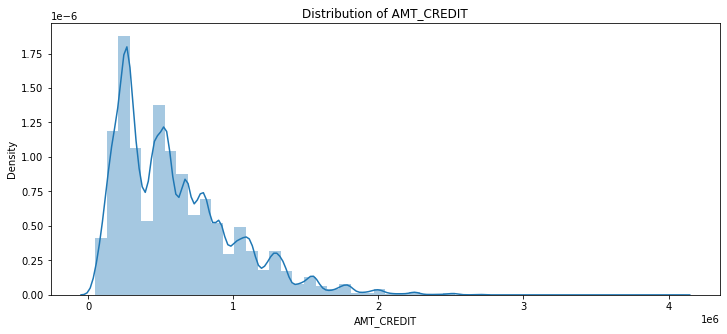

In [34]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(application_train["AMT_CREDIT"])

## Distribution of AMT_INCOME_TOTAL

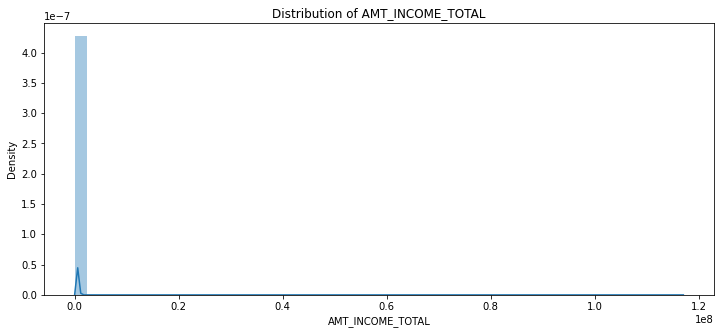

In [35]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(application_train["AMT_INCOME_TOTAL"].dropna())

In [69]:
application_train["AMT_INCOME_TOTAL"].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [70]:
application_train["AMT_CREDIT"].describe()

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

## Distribution of AMT_GOODS_PRICE

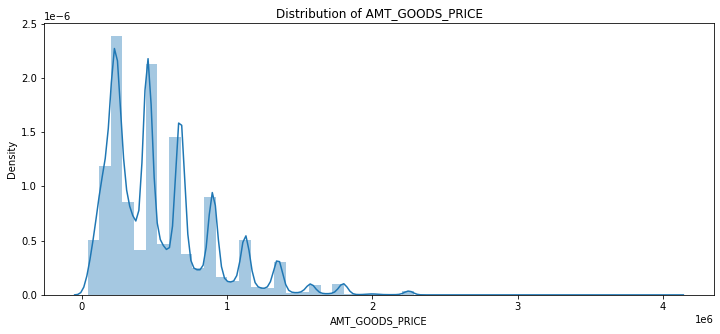

In [36]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(application_train["AMT_GOODS_PRICE"].dropna())

## Who accompanied client when applying for the  application

In [37]:
temp = application_train["NAME_TYPE_SUITE"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Who accompanied client when applying for the  application in % ",
    xaxis=dict(
        title='Name of type of the Suite',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Name of type of the Suite in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

## Data is balanced or imbalanced

In [38]:
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Loan Repayed or not')

* As we can see data is highly imbalanced.

## Types of loan

* **Rovolving loans :**  Arrangement which allows for the loan amount to be withdrawn, repaid, and redrawn again in any manner and any number of times, until the arrangement expires. Credit card loans and overdrafts are revolving loans. Also called evergreen loan

In [39]:
temp = application_train["NAME_CONTRACT_TYPE"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .48]},
      #"name": "Types of Loans",
      #"hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Types of loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Loan Types",
                "x": 0.17,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

* Most of the loans are Cash loans which were taken by applicants. **90.5 %** loans are Cash loans.

## Income sources of Applicant's who applied for loan

In [40]:
temp = application_train["NAME_INCOME_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Income sources of Applicant\'s', hole = 0.5)

* 51.6 % Applicants mentioned that they are working.  23.3 % are Commercial Associate and 18 % are Pensioner etc. 

## Family Status of Applicant's who applied for loan

In [41]:
temp = application_train["NAME_FAMILY_STATUS"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Family Status of Applicant\'s', hole = 0.5)

* 63.9 % applicants are married. 14.8 % are single etc.

## Occupation of Applicant's who applied for loan

In [42]:
temp = application_train["OCCUPATION_TYPE"].value_counts()
temp.iplot(kind='bar', xTitle = 'Occupation', yTitle = "Count", title = 'Occupation of Applicant\'s who applied for loan', color = 'green')

* **Top Applicant's who applied for loan :**
  * Laborers - Apprx. 55 K
  * Sales Staff - Approx. 32 K
  * Core staff - Approx. 28 K
  * Managers - Approx. 21 K
  * Drivers - Approx. 19 K

## Education of Applicant's who applied for loan

In [43]:
temp = application_train["NAME_EDUCATION_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Education of Applicant\'s', hole = 0.5)

* 71 % applicants have secondary and 24.3 % having higher education.

## For which types of house higher applicant's applied for loan ?

In [44]:
temp = application_train["NAME_HOUSING_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Type of House', hole = 0.5)

* Approx. 89 % peoples applied for loan, they mentioned type of house is **House / Appartment**.

## Types of Organizations who applied for loan 

In [45]:
temp = application_train["ORGANIZATION_TYPE"].value_counts()
temp.iplot(kind='bar', xTitle = 'Organization Name', yTitle = "Count", title = 'Types of Organizations who applied for loan ', color = 'red')

* **Types of Organizations who applied for loan :**
  * Business Entity Type 3 - Approx. 68 K
  * XNA - Approx. 55 K
  * Self employed - Approx. 38 K
  * Others - Approx. 17 K
  * Medicine - Approx. 11 K
 

# Exploration in terms of loan is repayed or not

## Income sources of Applicant's in terms of loan is repayed or not in %

In [46]:
temp = application_train["NAME_INCOME_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_INCOME_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_INCOME_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Income sources of Applicant's in terms of loan is repayed or not  in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Income source',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Family Status of Applicant's in terms of loan is repayed or not in %

In [47]:
temp = application_train["NAME_FAMILY_STATUS"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_FAMILY_STATUS"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_FAMILY_STATUS"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Family Status of Applicant's in terms of loan is repayed or not in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Family Status',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Occupation of Applicant's in terms of loan is repayed or not in %

In [48]:
temp = application_train["OCCUPATION_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["OCCUPATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["OCCUPATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Occupation of Applicant's in terms of loan is repayed or not in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Occupation of Applicant\'s',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Education of Applicant's in terms of loan is repayed or not in %

In [49]:
temp = application_train["NAME_EDUCATION_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_EDUCATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_EDUCATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Education of Applicant's in terms of loan is repayed or not in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Education of Applicant\'s',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## For which types of house higher applicant's applied for loan in terms of loan is repayed or not in %

In [50]:
temp = application_train["NAME_HOUSING_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_HOUSING_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_HOUSING_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "For which types of house higher applicant's applied for loan in terms of loan is repayed or not in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='types of house',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Types of Organizations in terms of loan is repayed or not in %

In [51]:
temp = application_train["ORGANIZATION_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["ORGANIZATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["ORGANIZATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Types of Organizations in terms of loan is repayed or not in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Types of Organizations',
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Distribution of Name of type of the Suite in terms of loan is repayed or not in %

In [52]:
temp = application_train["NAME_TYPE_SUITE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_TYPE_SUITE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_TYPE_SUITE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Distribution of Name of type of the Suite in terms of loan is repayed or not in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Name of type of the Suite',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Exploartion of previous application data

## Contract product type of previous application

In [53]:
temp = previous_application["NAME_CONTRACT_TYPE"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .48]},
      #"name": "Types of Loans",
      #"hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Contract product type of previous application",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Contract product type",
                "x": 0.12,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

* **Contract product type of previous application :**
  * Cash loans - 44.8 %
  * Consumer loans - 43.7 %
  * Rovolving loan - 11.6 %
  * XNA - 0.0207 %

## On which day highest number of clients applied in prevoies application

In [54]:
temp = previous_application["WEEKDAY_APPR_PROCESS_START"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "On which day highest number of clients applied in prevoies application in % ",
    xaxis=dict(
        title='Day of the Week',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Day of Week in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

* What a coincedence, Approximately 15 % clients applied in each 5 days a week i.e, Tuesday, Wednesday, Monday, Friday and Thrusday. 

## Purpose of cash loan in previous application

In [55]:
temp = previous_application["NAME_CASH_LOAN_PURPOSE"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Blues',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Purpose of cash loan in previous application in % ",
    xaxis=dict(
        title='Purpose of cash loan',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

* **Main purpose of the cash loan was  :**
  * XAP - 55 %
  * XNA - 41 %

## Contract was approved or not in previous application

In [56]:
temp = previous_application["NAME_CONTRACT_STATUS"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Contract approved or not', hole = 0.5)

* **Contract was approved or not in previous application :**
  * Approved : 62.1 % times
  * Cancelled : 18.9 % times
  * Refused : 17.4 % times 
  * Unused offer : 1.58 % times

## Payment method that client choose to pay for the previous application

In [57]:
temp = previous_application["NAME_PAYMENT_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Payment method that client choose to pay for the previous application', hole = 0.7,colors=['#75e575', '#ea7c96',])

* As we can most of the payment(61.9 %) has done thorugh cash only. 

## Why was the previous application rejected ?

In [58]:
temp = previous_application["CODE_REJECT_REASON"].value_counts()
temp.iplot(kind='bar', xTitle = 'Reason', yTitle = "Count", title = 'Top reasons of previous application rejection(Wriiten in some codes)', colors=['#75e575'])

## Was the client old or new client when applying for the previous application

In [59]:
temp = previous_application["NAME_CLIENT_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Was the client old or new client when applying for the previous application', hole = 0.7,colors=['#ea7c96','#75e575',])

* Approximately 74 % was repeater clients who applied for previous application.

## What kind of goods did the client apply for in the previous application

In [60]:
temp = previous_application["NAME_GOODS_CATEGORY"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Greens',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "What kind of goods did the client apply for in the previous application in % ",
    xaxis=dict(
        title='Name of the goods',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Was the previous application for CASH, POS, CAR, …

In [61]:
temp = previous_application["NAME_PORTFOLIO"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Was the previous application for CASH, POS, CAR, …', hole = 0.7,colors=['#ea7c96','#75e575',])

## Was the previous application x-sell or walk-in ?

In [62]:
temp = previous_application["NAME_PRODUCT_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Was the previous application x-sell or walk-in', hole = 0.7)

## Top channels  through which they acquired the client on the previous application

In [63]:
temp = previous_application["CHANNEL_TYPE"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
#         colorscale = 'Violet',
#         reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Top channels  through which they acquired the client on the previous application in % ",
    xaxis=dict(
        title='Name of the Channel',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

* **Top channels  through which they acquired the client on the previous application :**
  * Credidit and cash offices : 43 % times
  * Country_wide : 30 % times
  * Stone : 13 % times

## Top industry of the seller

In [64]:
temp = previous_application["NAME_SELLER_INDUSTRY"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Greens',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Top industry of the seller in % ",
    xaxis=dict(
        title='Industry Name',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Grouped interest rate into small medium and high of the previous application

In [65]:
temp = previous_application["NAME_YIELD_GROUP"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Greens',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Grouped interest rate into small medium and high of the previous application in % ",
    xaxis=dict(
        title='Grouped Interest rate',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Top Detailed product combination of the previous application

In [66]:
temp = previous_application["PRODUCT_COMBINATION"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Top Detailed product combination of the previous application', hole = 0.7)

## Did the client requested insurance during the previous application

In [67]:
temp = previous_application["NFLAG_INSURED_ON_APPROVAL"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Did the client requested insurance during the previous application(YES : 1, NO : 0)', hole = 0.7, colors=['#ea7c96','#75e575',])

# Pearson Correlation of features

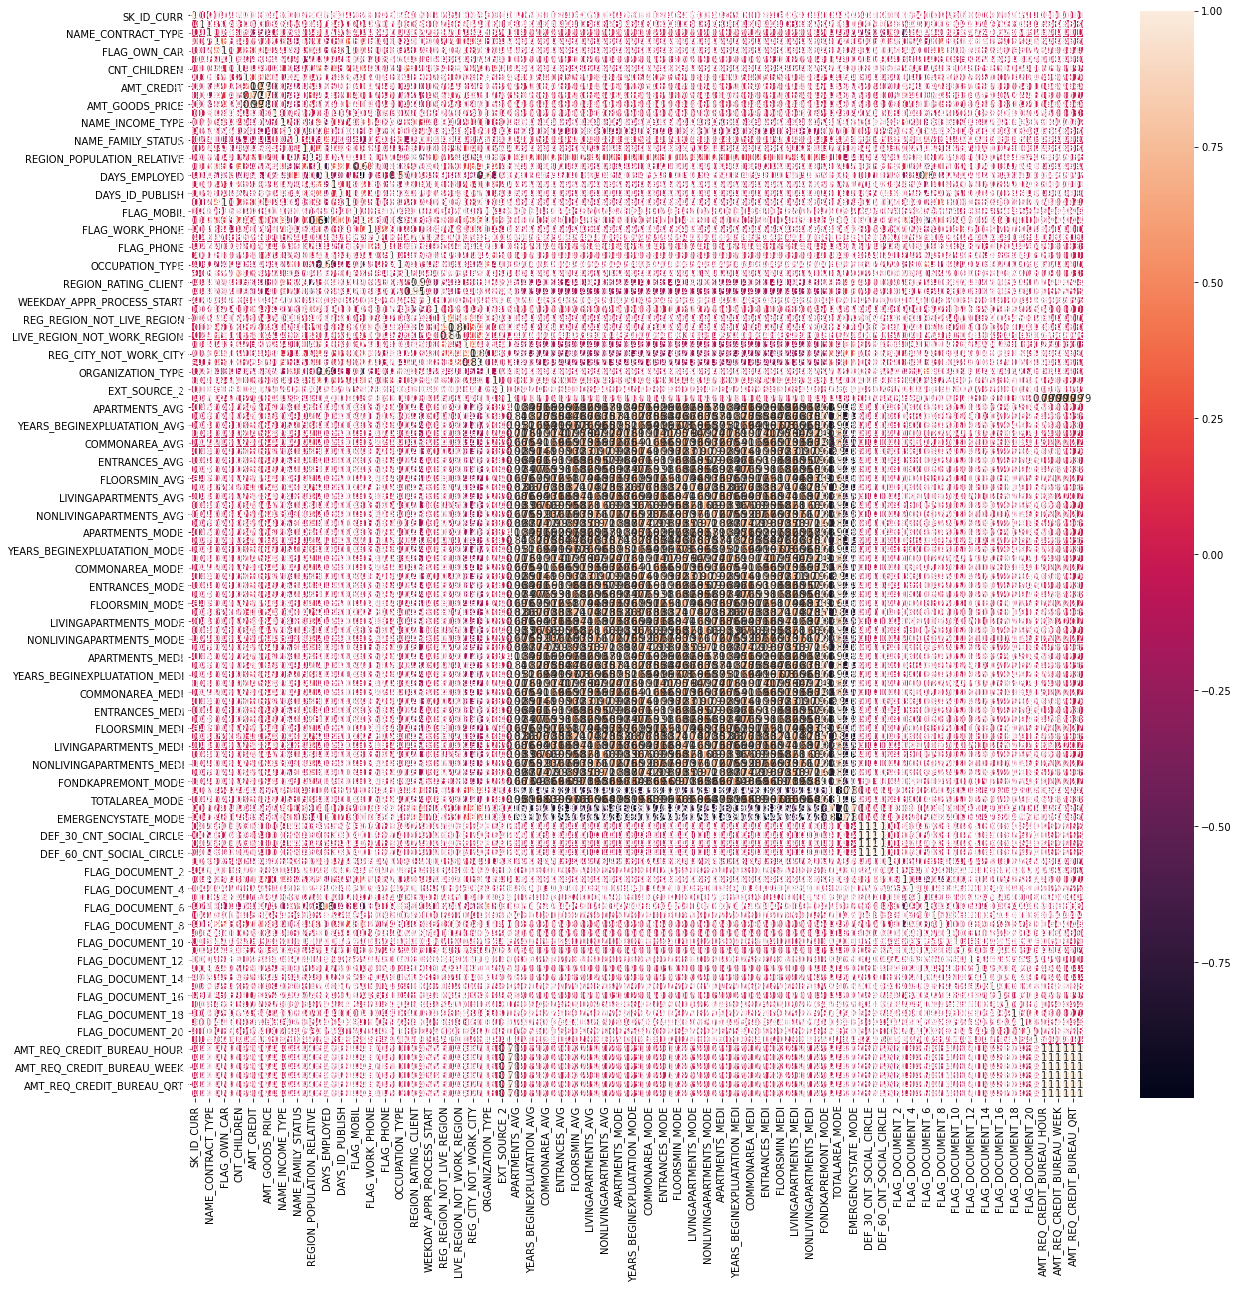

In [105]:

fig, ax = plt.subplots(figsize=(20,0))
ax = sns.heatmap(application_train.corr(), annot=True, linewidths=.5)
# ax.set_yticklabels([i.strftime("%Y-%m-%d %H:%M:%S") for i in df.index], rotation=0)

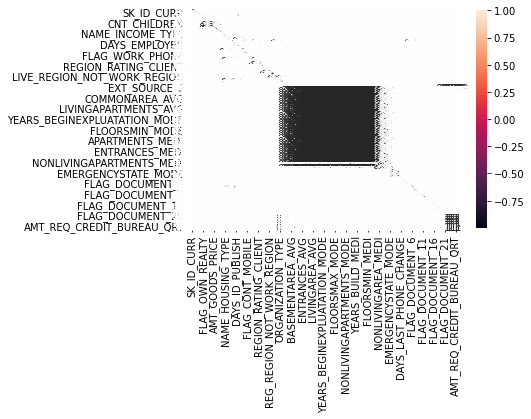

In [102]:
correlation_mat = application_train.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

[Text(0.5, 0, 'SK_ID_CURR'),
 Text(5.5, 0, 'FLAG_OWN_REALTY'),
 Text(10.5, 0, 'AMT_GOODS_PRICE'),
 Text(15.5, 0, 'NAME_HOUSING_TYPE'),
 Text(20.5, 0, 'DAYS_ID_PUBLISH'),
 Text(25.5, 0, 'FLAG_CONT_MOBILE'),
 Text(30.5, 0, 'REGION_RATING_CLIENT'),
 Text(35.5, 0, 'REG_REGION_NOT_WORK_REGION'),
 Text(40.5, 0, 'ORGANIZATION_TYPE'),
 Text(45.5, 0, 'BASEMENTAREA_AVG'),
 Text(50.5, 0, 'ENTRANCES_AVG'),
 Text(55.5, 0, 'LIVINGAREA_AVG'),
 Text(60.5, 0, 'YEARS_BEGINEXPLUATATION_MODE'),
 Text(65.5, 0, 'FLOORSMAX_MODE'),
 Text(70.5, 0, 'NONLIVINGAPARTMENTS_MODE'),
 Text(75.5, 0, 'YEARS_BUILD_MEDI'),
 Text(80.5, 0, 'FLOORSMIN_MEDI'),
 Text(85.5, 0, 'NONLIVINGAREA_MEDI'),
 Text(90.5, 0, 'EMERGENCYSTATE_MODE'),
 Text(95.5, 0, 'DAYS_LAST_PHONE_CHANGE'),
 Text(100.5, 0, 'FLAG_DOCUMENT_6'),
 Text(105.5, 0, 'FLAG_DOCUMENT_11'),
 Text(110.5, 0, 'FLAG_DOCUMENT_16'),
 Text(115.5, 0, 'FLAG_DOCUMENT_21'),
 Text(120.5, 0, 'AMT_REQ_CREDIT_BUREAU_QRT')]

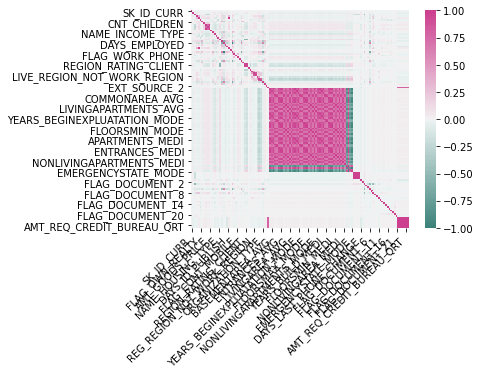

In [101]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# Feature Importance using Random forest

In [95]:
from sklearn import preprocessing
categorical_feats = [
    f for f in application_train.columns if application_train[f].dtype == 'object'
]

for col in categorical_feats:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(application_train[col].values.astype('str')) + list(application_test[col].values.astype('str')))
    application_train[col] = lb.transform(list(application_train[col].values.astype('str')))
    application_test[col] = lb.transform(list(application_test[col].values.astype('str')))

In [96]:
application_train.fillna(-999, inplace = True)

In [97]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=4, max_features=0.5, random_state=2018)
rf.fit(application_train.drop(['SK_ID_CURR', 'TARGET'],axis=1), application_train.TARGET)
features = application_train.drop(['SK_ID_CURR', 'TARGET'],axis=1).columns.values

In [98]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Client gender

Let's see the gender of the clients and also, on a separate plot, the percent of the loans (by client gender) with TARGET value 1 (not returned loan).

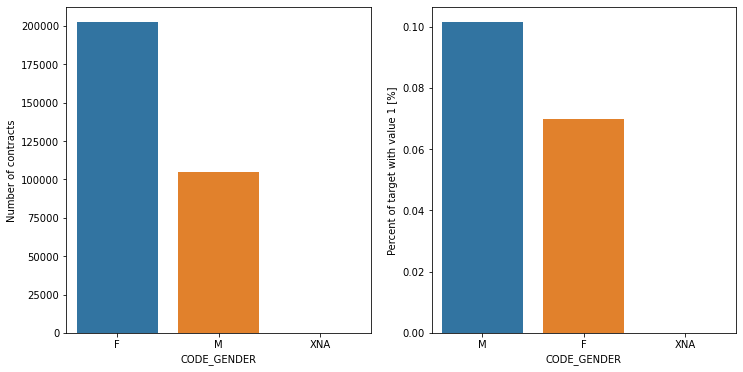

In [29]:
plot_stats('CODE_GENDER')

The number of female clients is almost double  the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (~10%), comparing with women (~7%).

### Flag own car and flag own real estate

Let's inspect the  flags that tell us if a client owns a car or real estate and, on separate plots, the percent of the loans value of these flags) with TARGET value 1 (not returned loan).

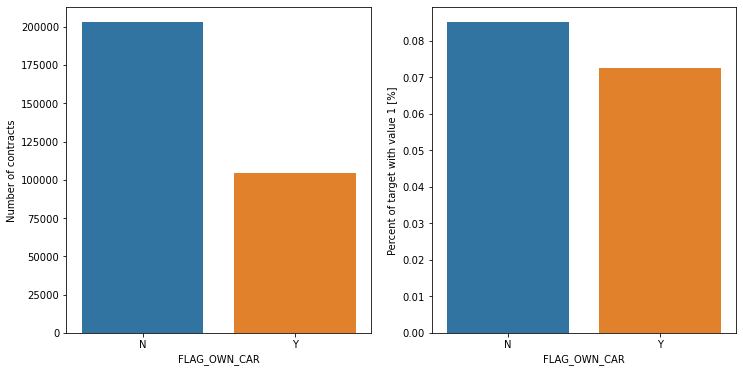

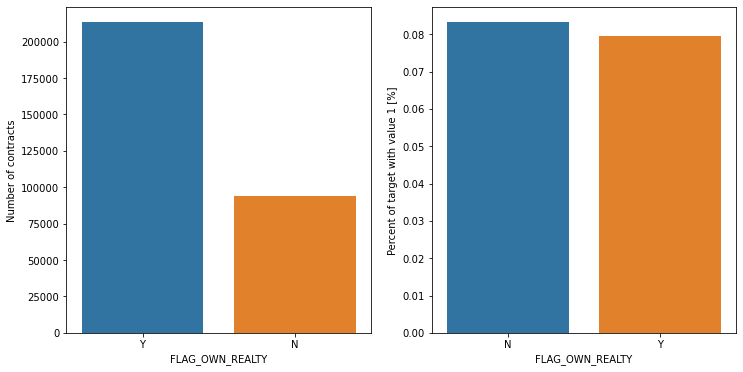

In [30]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

The clients that owns a car are almost a half of the ones that doesn't own one. The clients that owns a car are less likely to not repay a car that the ones that own. Both categories have not-repayment rates around 8%.

The clients that owns real estate are more than double of the ones that doesn't own. Both categories (owning real estate or not owning) have not-repayment rates less than 8%.


### Family status of client

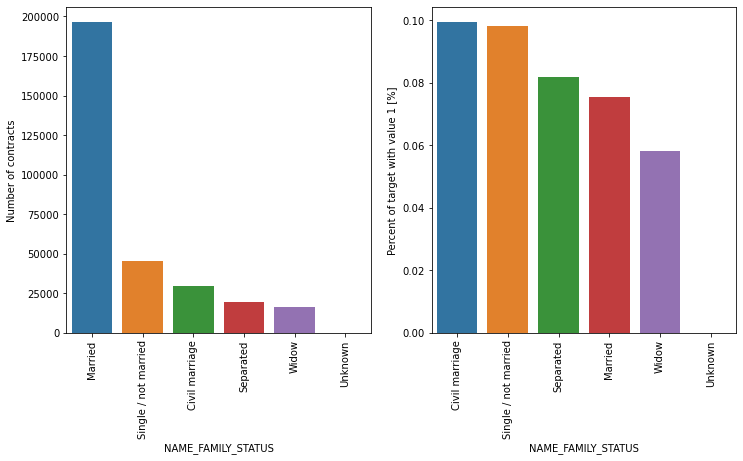

In [31]:
plot_stats('NAME_FAMILY_STATUS',True, True)

Most of clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment (10%), with Widow the lowest (exception being *Unknown*).

### Number of children

Let's see what is the distribution of the number of children of the clients.

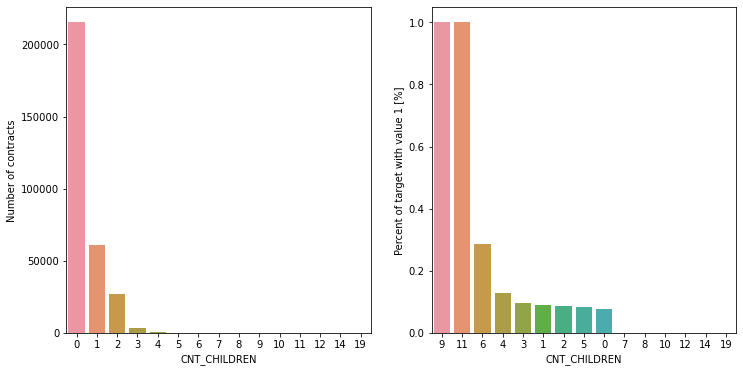

In [32]:
plot_stats('CNT_CHILDREN')

Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare. 

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.



### Number of family members of client

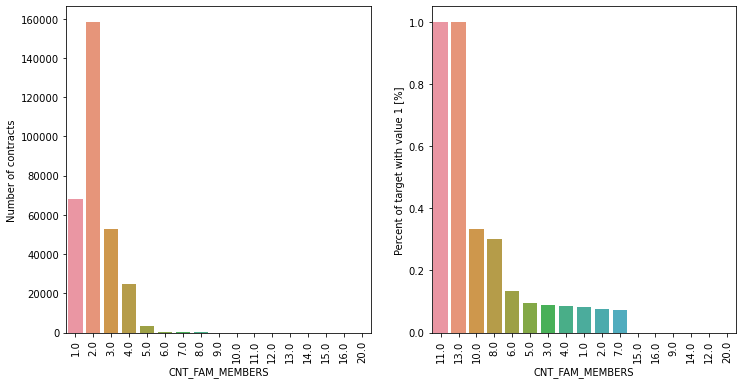

In [33]:
plot_stats('CNT_FAM_MEMBERS',True)

Clients with family members of 2 are most numerous, followed by 1 (single persons), 3 (families with one child) and 4.

Clients with family size of 11 and 13 have 100% not repayment rate. Other families with 10 or 8 members have percents of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.


### Income type of client

Let's investigate the numbers of clients with different income type. As well, let's see the percent of not returned loans per income type of applicants.

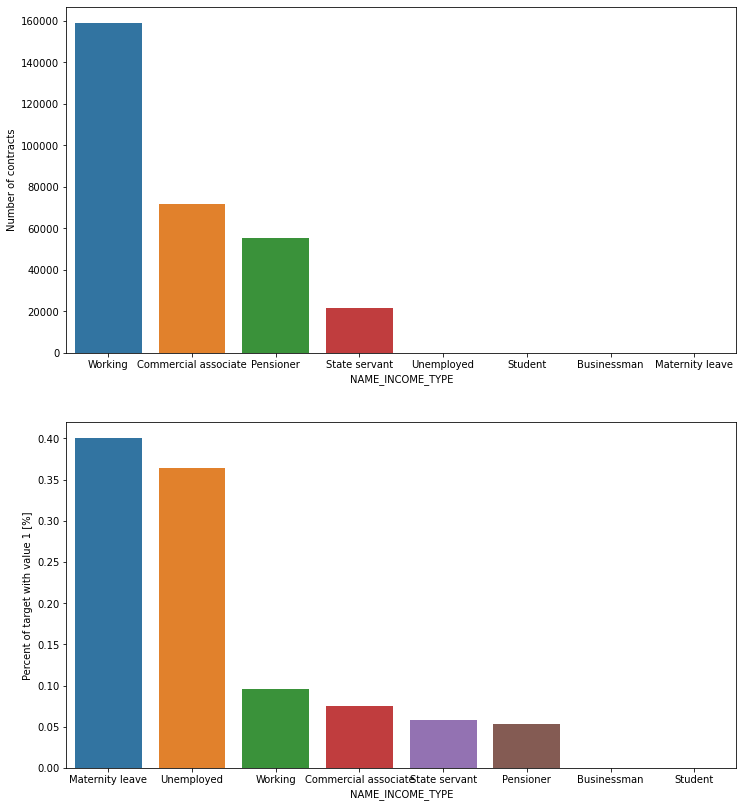

In [34]:
plot_stats('NAME_INCOME_TYPE',False,False)

Most of applicants for loans are income from *Working*, followed by *Commercial associate*, *Pensioner* and *State servant*.

The applicants with the type of income *Maternity leave* have almost 40% ratio of not returning loans, followed by *Unemployed* (37%). The rest of types of incomes are under the average of 10% for not returning loans.


### Ocupation of client



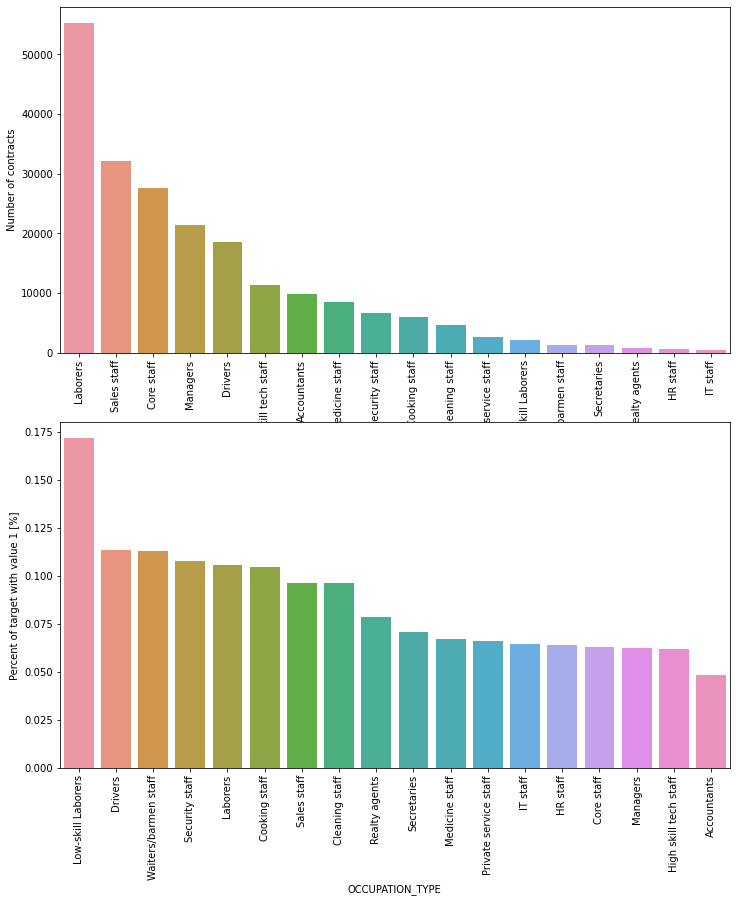

In [35]:
plot_stats('OCCUPATION_TYPE',True, False)

Most of the loans are taken by *Laborers*, followed by *Sales staff*. *IT staff* take the lowest amount of loans.

The category with highest percent of not repaid loans are *Low-skill Laborers* (above 17%), followed by *Drivers* and *Waiters/barmen staff*, *Security staff*, *Laborers* and *Cooking staff*.

### Organization type

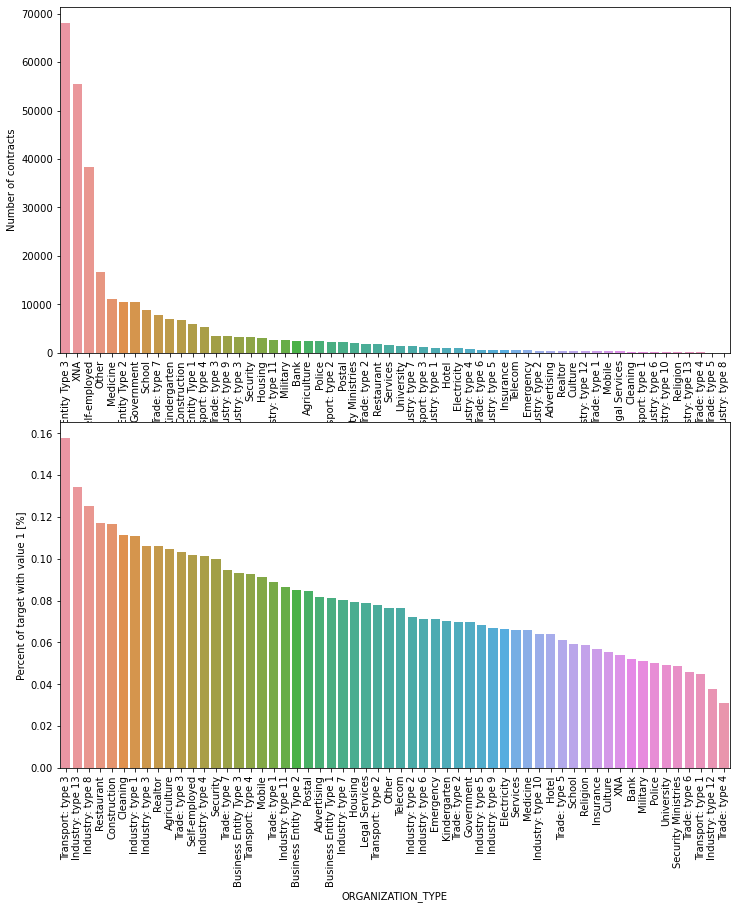

In [36]:
plot_stats('ORGANIZATION_TYPE',True, False)

Oraganizations with highest percent of loans not repaid are *Transport: type 3* (16%), *Industry: type 13* (13.5%), *Industry: type 8* (12.5%) and *Restaurant* (less than 12%).

### Education type of the client

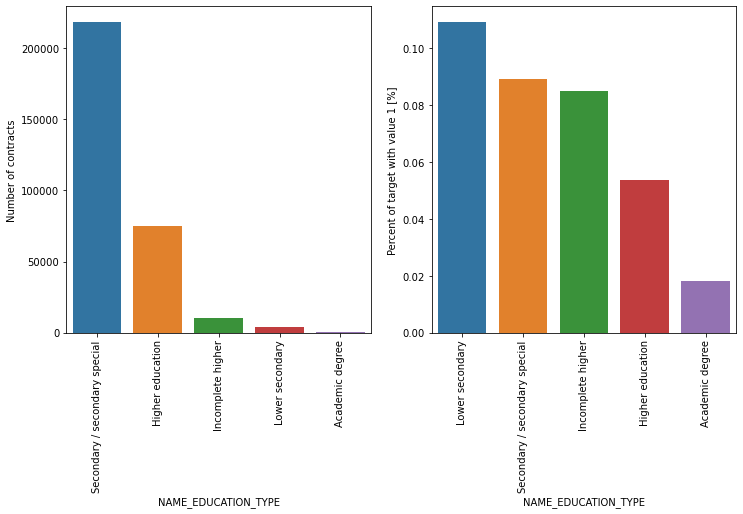

In [37]:
plot_stats('NAME_EDUCATION_TYPE',True)

Majority of the clients have Secondary / secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.

The Lower secondary category, although rare, have the largest rate of not returning the loan (11%). The people with Academic degree have less than 2% not-repayment rate.


### Type of the housing of client

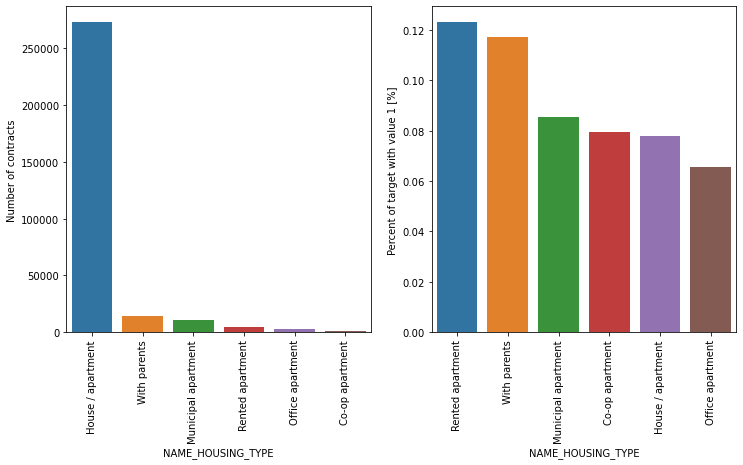

In [38]:
plot_stats('NAME_HOUSING_TYPE',True)

Over 250,000 applicants for credits registered their housing as House/apartment. Following categories have a very small number of clients (With parents, Municipal appartment).

From these categories, *Rented apartment* and *With parents* have higher than 10% not-repayment rate.

### Total income distribution

Let's plot the distribution of total income for the clients.

In [39]:
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(application_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()   

In [40]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = application_train.loc[application_train['TARGET'] != 0]
    t0 = application_train.loc[application_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


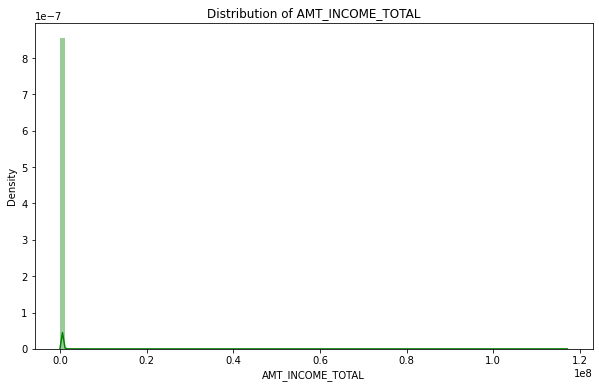

In [41]:
plot_distribution('AMT_INCOME_TOTAL','green')


### Credit distribution

Let's plot the credit distribution.

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


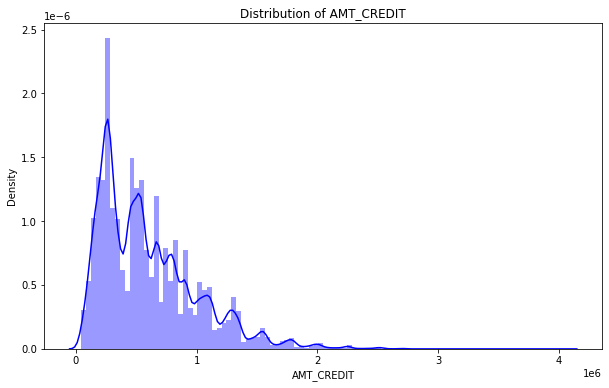

In [42]:
plot_distribution('AMT_CREDIT','blue')

### Annuity distribution

Let's plot the annuity distribution.

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


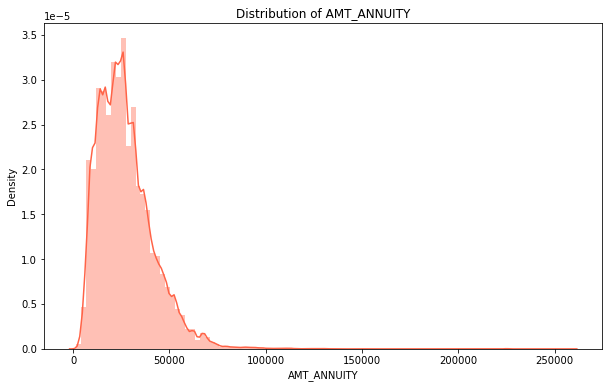

In [43]:
plot_distribution('AMT_ANNUITY','tomato')

### Goods price

Let's plot the good price distribution.

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


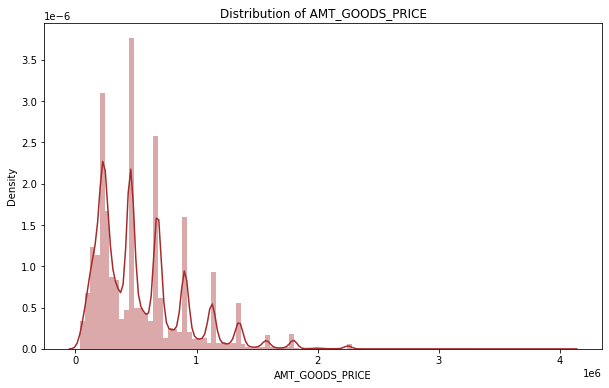

In [44]:
plot_distribution('AMT_GOODS_PRICE','brown')

### Days from birth distribution

Let's plot the distribution number of days from birth.

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


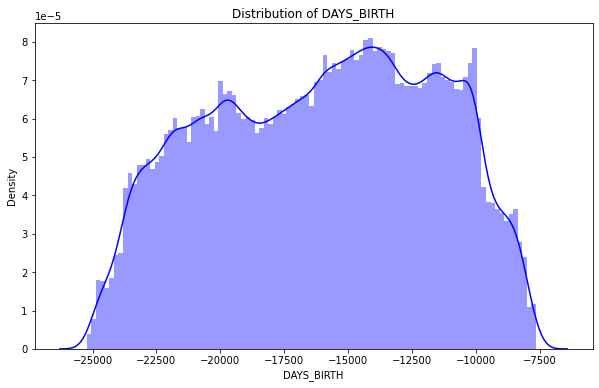

In [45]:
plot_distribution('DAYS_BIRTH','blue')

The negative value means that the date of birth is in the past. The age range is between approximative 20 and 68 years.

### Days employed distribution

Let's represent the distribution of number of days employed.

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


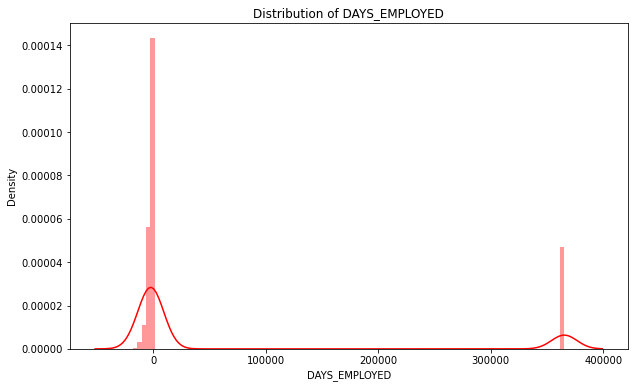

In [46]:
plot_distribution('DAYS_EMPLOYED','red')

The negative values means *Days since employed* and most probably these negative values means *Unemployed*. It is not clear what will be the meaning of the very large numbers at the far end (it is not realistic such a large set of people employed more than 100 years).


### Days of registration distribution

Let's plot the distribution of `DAYS_REGISTRATION`.

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


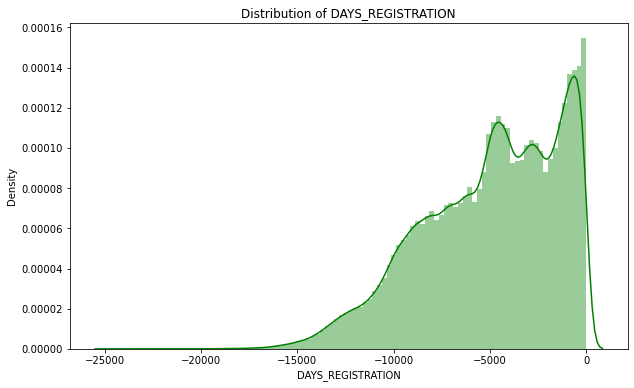

In [47]:
plot_distribution('DAYS_REGISTRATION','green')

### Days ID publish distribution

Let's plot the distribution of DAYS_ID_PUBLISH.

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


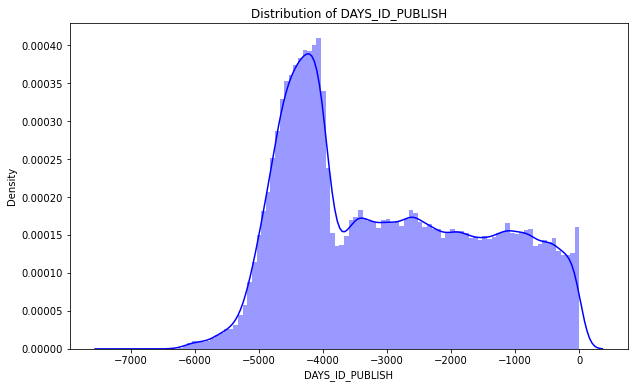

In [48]:
plot_distribution('DAYS_ID_PUBLISH','blue')

### Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of **TARGET = 1** and **TARGET = 0**

/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/krystal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distribu

<Figure size 432x288 with 0 Axes>

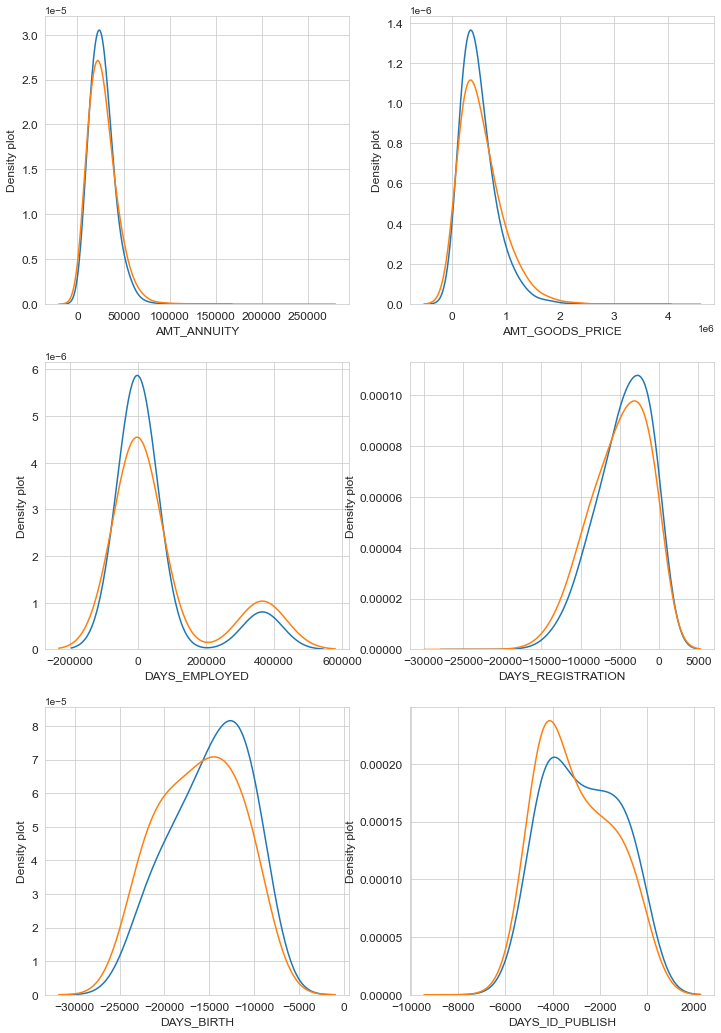

In [49]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(var,nrow=3)

### Region registered not live region and not work region

Let's represent the values of region registered and not live region and region registered and not work region.

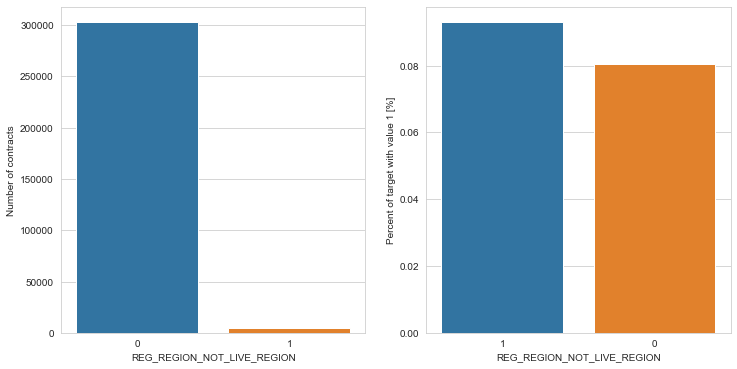

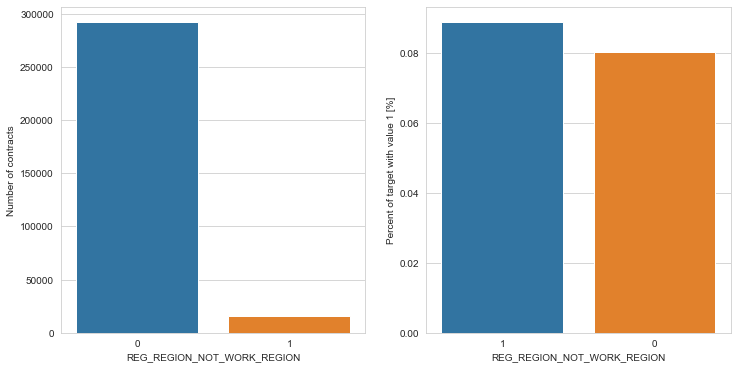

In [50]:
plot_stats('REG_REGION_NOT_LIVE_REGION')
plot_stats('REG_REGION_NOT_WORK_REGION')

Very few people are registered in not live or not work region. Generally, the rate of not return is slightly larger for these cases than in the rest (slightly above 8% compared with approx. 8%)

### City registered not live city and not work city

Let's represent the values of City registered not live city and not work city.

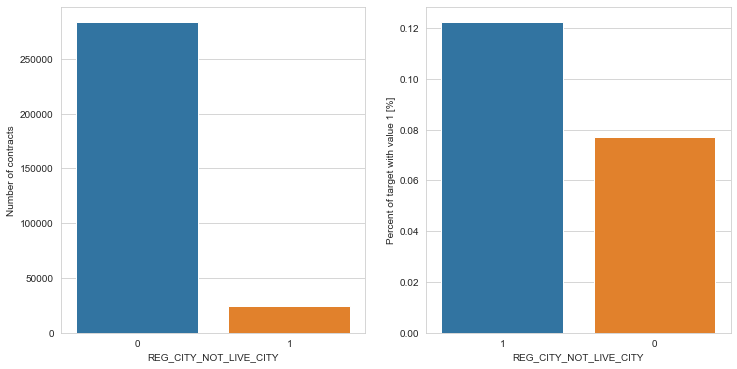

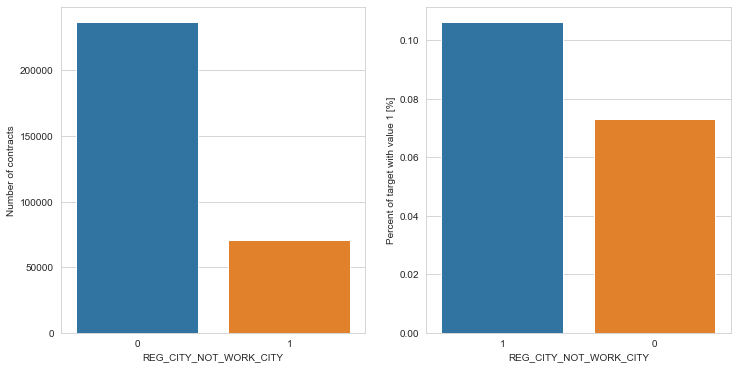

In [51]:
plot_stats('REG_CITY_NOT_LIVE_CITY')
plot_stats('REG_CITY_NOT_WORK_CITY')

Generally, much more people register in the city they live or work (a larger number register differently in the working city than living city).

The ones that register in different city than the working or living city are more frequently not-repaying the loans than the ones that register same city (work 11% or live 12%).

<a href="#0"><font size="1">Go to top</font></a>


## <a id="42">Bureau data</a>

Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. **SK_ID_CURR** is the key connecting *application_train*|*test* data with *bureau* data.

Let's merge *application_train* with *bureau*.

In [52]:
application_bureau_train = application_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [53]:
print("The resulting dataframe `application_bureau_train` has ",application_bureau_train.shape[0]," rows and ", 
      application_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


Let's now analize the *application_bureau_train* data.

In [54]:
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Credit status

Let's see the credit status distribution. We show first the number of credits per category (could be *Closed*, *Active*, *Sold* and *Bad debt*).

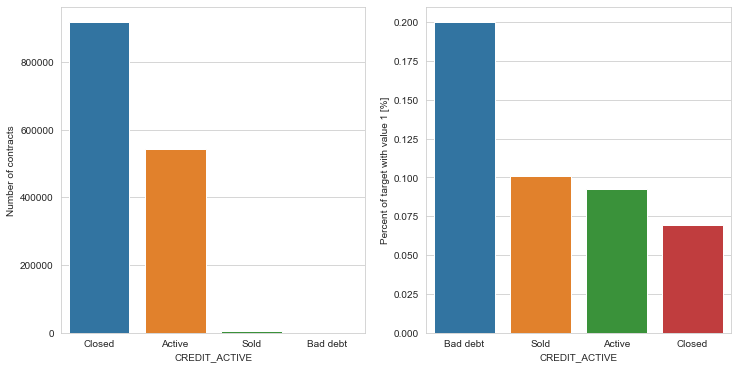

In [55]:
plot_b_stats('CREDIT_ACTIVE')

Most of the credits registered at the Credit Bureau are in the status *Closed* (~900K). On the second place are the *Active* credits ( a bit under 600K). *Sold* and *Bad debt* are just a few.

In the same time, as percent having **TARGET = 1** from total number per category, clients with credits registered to the Credit Bureau with *Bad debt* have 20%  default on the currrent applications. 


Clients with credits *Sold*, *Active* and *Closed* have percent of **TARGET == 1** (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with *Closed* credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the dafault credit, since the percent of applications defaulting with a history of *Bad debt* is twice as large as for *Sold* or *Active* and almost three times larger as for *Closed*.

### Credit currency

Let's check now the number of credits registered at the Credit Bureau with different currencies. Also, let's check procent of defaulting credits (for current applications) per different currencies of credits credits registered at the Credit Bureau in the past for the same client.

In [ ]:
plot_b_stats('CREDIT_CURRENCY')

Credits are mostly in *currency_1*.

Depending on the currency, the percent of clients defaulting is quite different. Starting with *currency_3*, then *currency_1* and *currency_2*, the percent of clients defaulting is 11%, 8% and 5%. Percent of defaulting applications for clients that have credits registered with *currency_4* is close to 0.

### Credit type

Let's check now the credit types for credits registered at the Credit Bureau.

In [ ]:
plot_b_stats('CREDIT_TYPE', True, True)

Majority of historical credits registered at the Credit Bureau are *Consumer credit* and *Credit card*. Smaller number of credits are *Car loan*, *Mortgage* and *Microloan*.

Looking now to the types of historical credits registered at the Credit Bureau, there are few types with a high percent of current credit defaults, as following:  
* *Loan for the purchase of equipment* - with over 20% current credits defaults;  
* *Microloan* - with over 20% current credits defaults;  
* *Loan for working capital replenishement* - with over 12% current credits defaults.  


### Duration of credit (DAYS_CREDIT)

Let's check the distribution of number of days for the credit (registered at the Credit bureau).


In [ ]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(application_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year).

### Credit overdue (CREDIT_DAY_OVERDUE)

Let's check the distribution of number of days for the credit overdue (registered at the Credit bureau).

In [ ]:
plot_b_distribution('CREDIT_DAY_OVERDUE','red')

Most of the credits have 0 or close to 0 days overdue. The maximum number of credit days overdue is ~3000 days.

### Credit sum  (AMT_CREDIT_SUM)

In [ ]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

The distribution of the AMT_CREDIT_SUM shows a concentration of the credits for the lower credit sum range.

Let's remove the outliers so that we can see better the distribution around 0.

Let's introduce a function to identify and filter the outliers (with a predefined threshold). 

Then, let's also modify the function to display a distribution, this time by using the function to filter the outliers.

In [ ]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting (see references)

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def plot_b_o_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    x = application_bureau_train[feature].dropna()
    filtered = x[~is_outlier(x)]
    sns.distplot(filtered,color=color, kde=True,bins=100)
    plt.show() 

plot_b_o_distribution('AMT_CREDIT_SUM','blue')

We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

### Credit sum limit (AMT_CREDIT_SUM_LIMIT)

In [ ]:
plot_b_distribution('AMT_CREDIT_SUM_LIMIT','blue')

### Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of **TARGET = 1** and **TARGET = 0**

In [ ]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_b_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = application_bureau_train.loc[application_bureau_train['TARGET'] != 0]
    t0 = application_bureau_train.loc[application_bureau_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [ ]:
var = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']

plot_b_distribution_comp(var, nrow=2)

<a href="#0"><font size="1">Go to top</font></a>

## <a id="43">Previous application data</a>


The dataframe *previous_application* contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. **SK_ID_CURR** is the key connecting *application_train*|*test* data with *previous_application* data.

Let's merge *application_train* with *previous_application*.

In [ ]:
application_prev_train = application_train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [ ]:
print("The resulting dataframe `application_prev_train` has ",application_prev_train.shape[0]," rows and ", 
      application_prev_train.shape[1]," columns.")

In [ ]:
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

<a href="#0"><font size="1">Go to top</font></a>


## <a id="44">Contract type</a>


In [ ]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

There are three types of contract in the previous application data: *Cash loans*, *Consumer loans*, *Revolving loans*. *Cash loans* and *Consumer loans* are almost the same number (~600K) whilst *Revolving loans* are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for *Revolving loans*, then ~ 9.5% for *Cash loans* and ~8% for *Consumer loans*.

### Cash loan purpose

Let's look to the cash loan purpose, in the case of cash loans.

In [ ]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

Besides not identifed/not available categories, *Repairs*, *Other*, *Urgent needs*, *Buying a used car*, *Building a house or an annex* accounts for the largest number of contracts.


In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history are previous applications for cash loans for *Refusal to name the goal* - ~23% (which makes a lot of sense), *Hobby* (20%), *Car repairs* (~18%).

### Contract status

Let's look to the contract status.

In [ ]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

Most previous applications contract statuses are *Approved* (~850K), *Canceled* and *Refused* (~240K). There are only ~20K in status *Unused offer*.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are *Refused* (12%), followed by *Canceled* (9%), *Unused offer* (~8%) and *Approved* (lowest percent of defaults in current applictions, with less than 8%).

### Payment type

Let's check the payment type.

In [ ]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

Most of the previous applications were paid with *Cash through the bank* (~850K). Payments using *Non-cash from your account* or *Cashless from the account of the employer* are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (~8% each).

### Client type

Let's check the client type for previous applications.

In [ ]:
plot_p_stats('NAME_CLIENT_TYPE')

Most of the previous applications have client type *Repeater* (~1M), just over 200K are *New* and ~100K are *Refreshed*.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past *New*, *Repeater* and *Refreshed*, respectivelly.

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [21]:
app_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

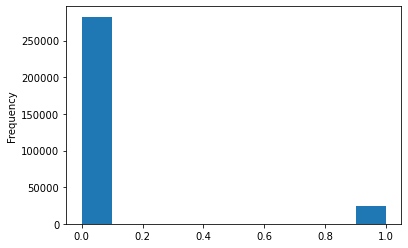

In [22]:
app_train['TARGET'].astype(int).plot.hist()

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Examine Missing Values

Next we can look at the number and percentage of missing values in each column. 

In [27]:
app_train.isnull().sum()/len(app_train)

SK_ID_CURR                    0.000000
TARGET                        0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 122, dtype: float64

In [42]:
app_train.isnull().sum()[app_train.isnull().sum()>0]

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 67, dtype: int64

In [32]:
pd.concat([app_train.isnull().sum(),app_train.isnull().sum()/len(app_train)], axis=1).rename({0:"Missing values",1:"% Missing values"}, axis=1)

Missing values  % Missing values
SK_ID_CURR                               0          0.000000
TARGET                                   0          0.000000
NAME_CONTRACT_TYPE                       0          0.000000
CODE_GENDER                              0          0.000000
FLAG_OWN_CAR                             0          0.000000
...                                    ...               ...
AMT_REQ_CREDIT_BUREAU_DAY            41519          0.135016
AMT_REQ_CREDIT_BUREAU_WEEK           41519          0.135016
AMT_REQ_CREDIT_BUREAU_MON            41519          0.135016
AMT_REQ_CREDIT_BUREAU_QRT            41519          0.135016
AMT_REQ_CREDIT_BUREAU_YEAR           41519          0.135016

[122 rows x 2 columns]

In [154]:
# Function to calculate missing values by column# 
def missing_value_table(df):
    
    ##total missing value by each column
    mis_val =df.isnull().sum()[df.isnull().sum()>0]
  
    # Percentage of missing values
    mis_val_percent = mis_val/len(app_train)

    #Make a table with the results
    mis_val_table = pd.concat([ mis_val,mis_val_percent], axis=1).rename({0:"Missing values",1:"% Missing values"}, axis=1)
    
    # Print some summary information
    print("Your dataframe contains " + str(df.shape[1]) + " columns\n"
         "There are " + str(mis_val_table.shape[0]) +" columns that have missing values")
    
    return mis_val_table.sort_values(by = "% Missing values", ascending = False) 

In [155]:
missing_values = missing_value_table(app_train)
missing_values 

Your dataframe contains 241 columns
There are 62 columns that have missing values


Missing values  % Missing values
COMMONAREA_MODE                   214865          0.698723
COMMONAREA_AVG                    214865          0.698723
COMMONAREA_MEDI                   214865          0.698723
NONLIVINGAPARTMENTS_MEDI          213514          0.694330
NONLIVINGAPARTMENTS_AVG           213514          0.694330
...                                  ...               ...
EXT_SOURCE_2                         660          0.002146
AMT_GOODS_PRICE                      278          0.000904
AMT_ANNUITY                           12          0.000039
CNT_FAM_MEMBERS                        2          0.000007
DAYS_LAST_PHONE_CHANGE                 1          0.000003

[62 rows x 2 columns]

When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) .

In [54]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Let's now look at the number of unique entries in each of the `object` (categorical) columns.

In [58]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. [Here is a good Stack Overflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) or other [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) to reduce the number of dimensions (while still trying to preserve information). 

In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [59]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [60]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [64]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding.

## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:



In [65]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [66]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

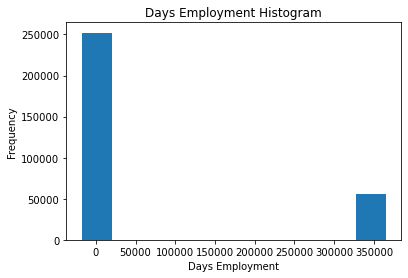

In [67]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

Let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [80]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print("The non-anomalies mean default rate is " + str(100 * non_anom['TARGET'].mean()) +"%")
print("The anomalies mean default rate is " + str(100 * anom['TARGET'].mean()) +"%")
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies mean default rate is 8.65997453765215%
The anomalies mean default rate is 5.399646043269405%
There are 55374 anomalous days of employment


It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.

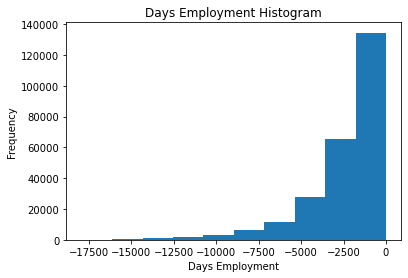

In [83]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with `np.nan` in the testing data

In [84]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson linear correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [87]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [88]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

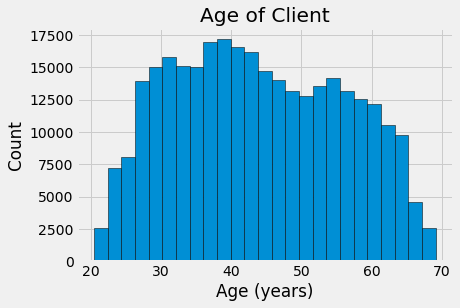

In [89]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

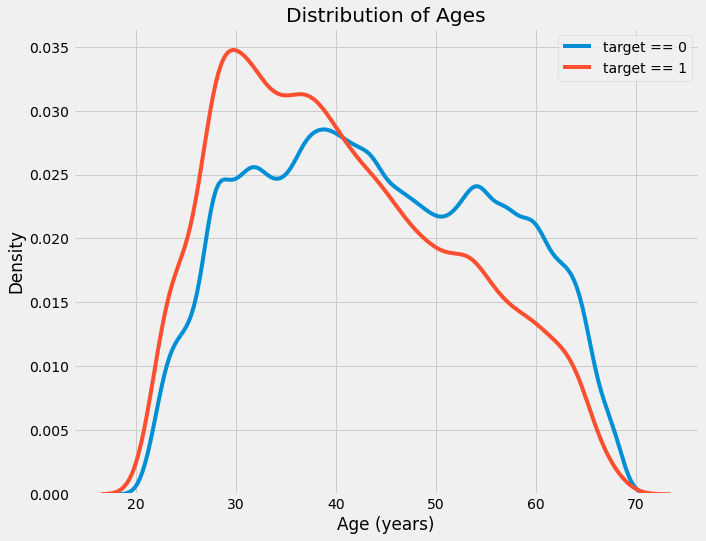

In [91]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


plt.legend()

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [93]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

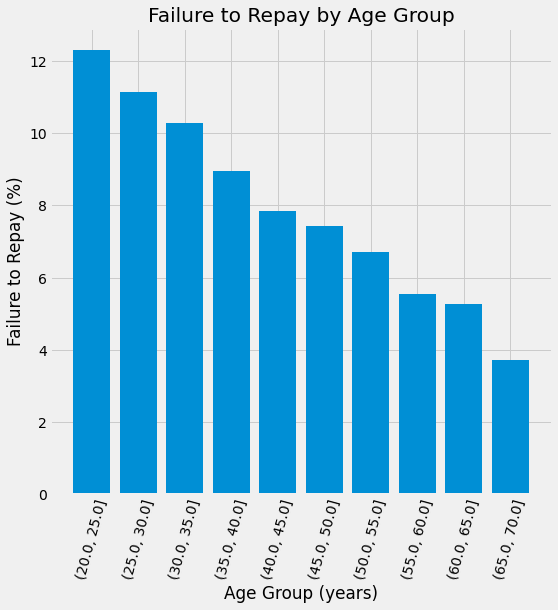

In [94]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [95]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

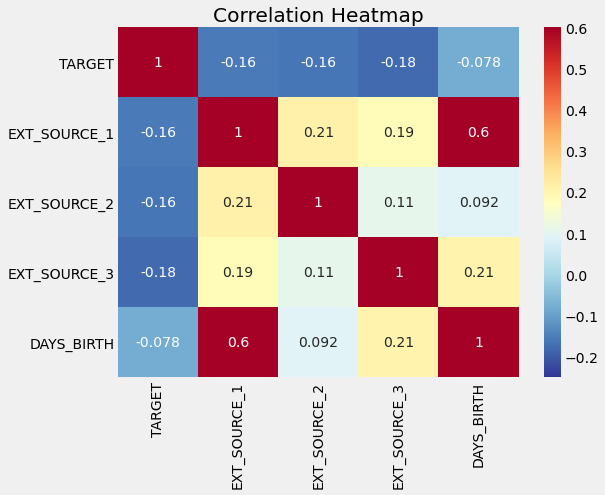

In [96]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

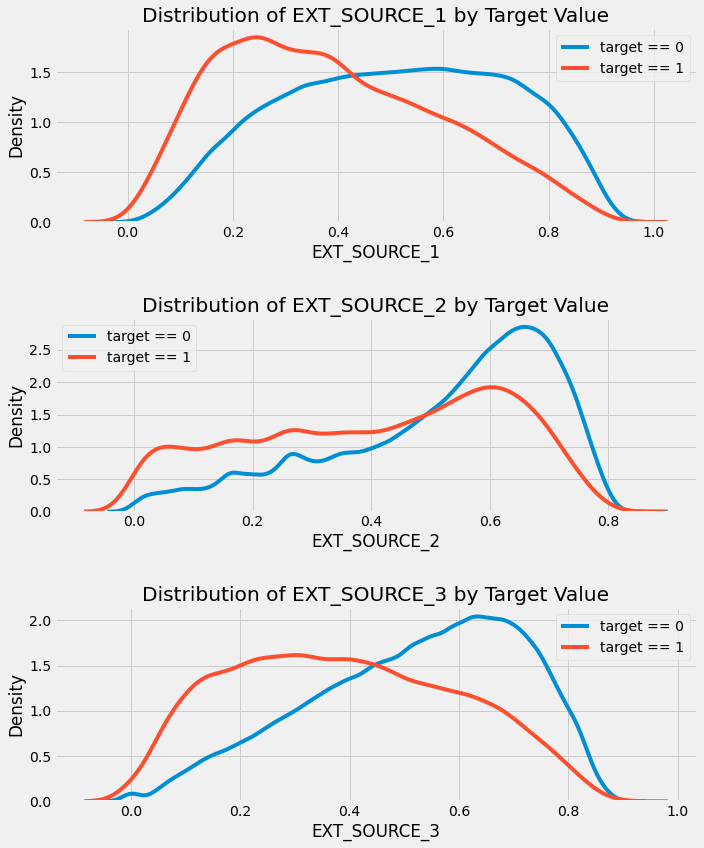

In [98]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pairs Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

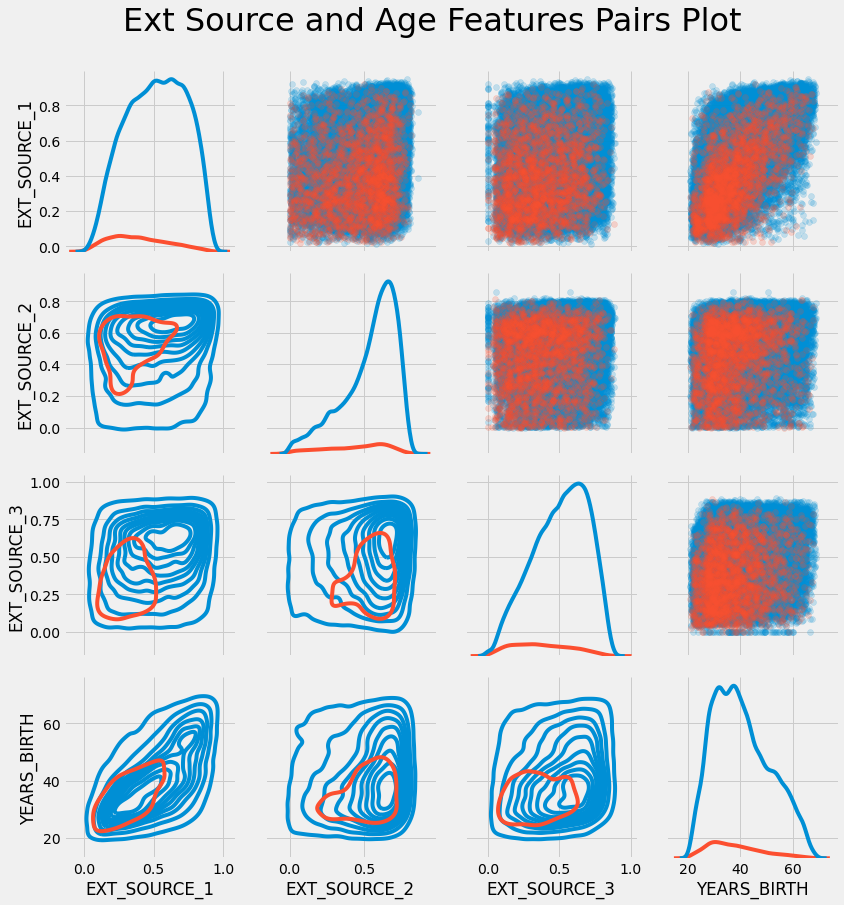

In [99]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client. 

# Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on [gradient boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. [This is a great article on the subject)](https://www.featurelabs.com/blog/secret-to-data-science-success/). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering." 

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some [automated tools](https://docs.featuretools.com/getting_started/install.html) to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods: 

* Polynomial features
* Domain knowledge features


## Polynomial Features

One simple feature construction method is called [polynomial features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1^2` and `EXT_SOURCE_2^2` and also variables such as `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x   `EXT_SOURCE_2^2`, and so on. These features that are a combination of multiple individual variables are called [interaction terms](https://en.wikipedia.org/wiki/Interaction_(statistics) because they  capture the interactions between variables. In other words, while two variables by themselves  may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. [Interaction terms are commonly used in statistical models](https://www.theanalysisfactor.com/interpreting-interactions-in-regression/) to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan. 

Jake VanderPlas writes about [polynomial features in his excellent book Python for Data Science](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html) for those who want more information.

In the following code, we create polynomial features using the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. [Scikit-Learn has a useful class called `PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into [problems with overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)). 

In [103]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [104]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [105]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [106]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn. 

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out! 

In [108]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [109]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [111]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

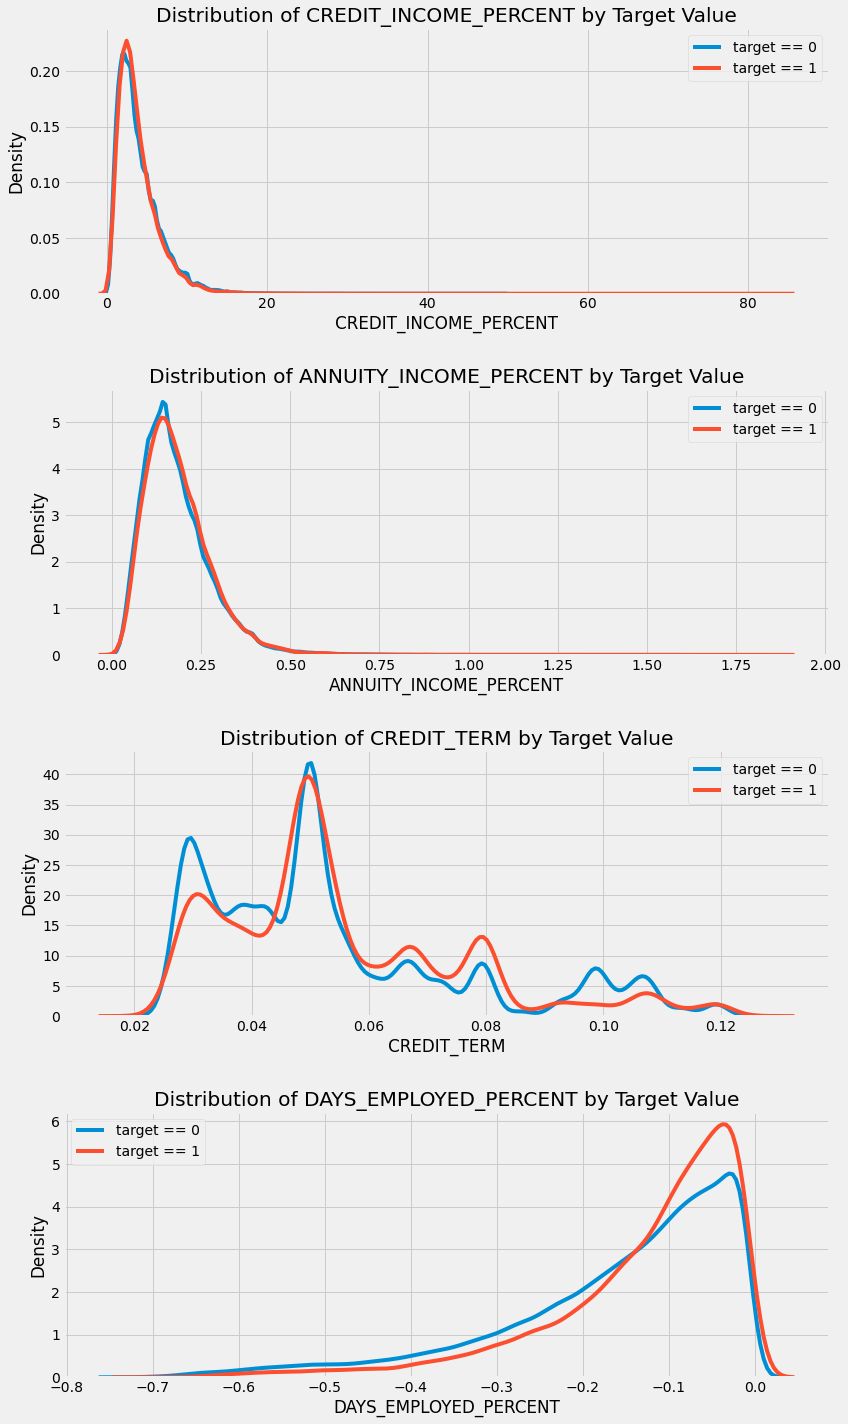

In [114]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

## Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective! 

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

### Data Pre-processing

In [118]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


We will use [`LogisticRegression`from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using `.fit` and then we make predictions on the testing data using `.predict_proba` (remember that we want probabilities and not a 0 or 1).

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model `predict.proba` method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

In [121]:
# Make predictions
# Make sure to select the second column which is the probability of being 1(not repay the loan)
log_reg_pred = log_reg.predict_proba(test)[:, 1]

The predictions must be in the format shown in the `sample_submission.csv` file, where there are only two columns: `SK_ID_CURR` and `TARGET`. We will create a dataframe in this format from the test set and the predictions called `submit`. 

In [130]:
# Submission dataframe
submit = app_test[["SK_ID_CURR"]]
submit["Target"] = log_reg_pred
submit

SK_ID_CURR    Target
0          100001  0.078515
1          100005  0.137926
2          100013  0.082194
3          100028  0.080921
4          100038  0.132618
...           ...       ...
48739      456221  0.098639
48740      456222  0.095744
48741      456223  0.077225
48742      456224  0.082389
48743      456250  0.102135

[48744 rows x 2 columns]

The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky. 

## Improved Model: Random Forest

To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [131]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [132]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


In [133]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
submit.head()

SK_ID_CURR  TARGET
0      100001    0.13
1      100005    0.21
2      100013    0.05
3      100028    0.14
4      100038    0.20

### Make Predictions using Engineered Features

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [134]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [135]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [136]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
submit.head()

SK_ID_CURR  TARGET
0      100001    0.37
1      100005    0.37
2      100013    0.33
3      100028    0.29
4      100038    0.44

#### Testing Domain Features

Now we can test the domain features we made by hand.

In [137]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


In [138]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
submit.head()

SK_ID_CURR  TARGET
0      100001    0.18
1      100005    0.25
2      100013    0.16
3      100028    0.11
4      100038    0.18

## Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the `EXT_SOURCE` and the `DAYS_BIRTH`. We may use these feature importances as a method of dimensionality reduction in future work.

In [140]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

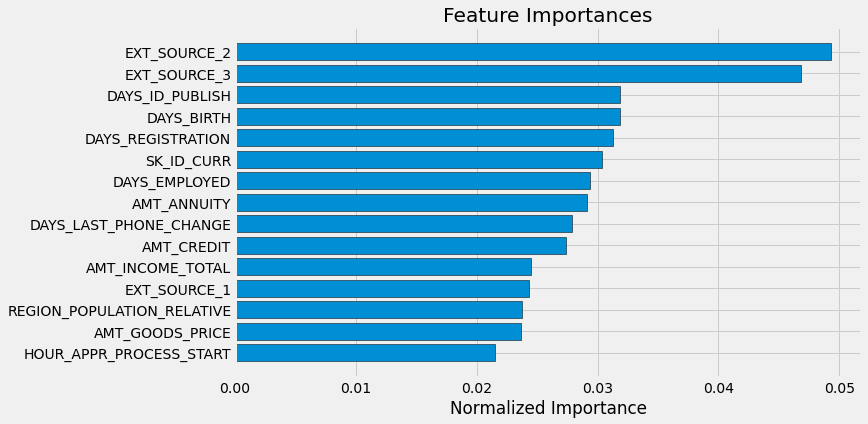

In [141]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)